In [1]:
import os

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random
import pandas as pd
from tifffile import imread
import ffmpeg
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

### Parameters and path

In [2]:
folder_save = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\LatrunculinA\5uM\2x\representative_overlay_image"

os.chdir(folder_save)
lst_fname_tracks = [f for f in os.listdir(".") if f.endswith(".csv")]
lst_fname_cell = [f for f in os.listdir(".") if f.endswith(".txt")]

color_blue = "#00274c"
color_red = "#c61a3e"

### Functions

In [3]:
def find_consecutive_true_ranges(bool_array):
    ranges = []
    n = len(bool_array)
    i = 0

    while i < n:
        if bool_array[i]:
            start = i
            while i < n and bool_array[i]:
                i += 1
            end = i - 1
            ranges.append((start, end))
        i += 1

    return ranges


def find_consecutive_false_ranges(bool_array):
    ranges = []
    n = len(bool_array)
    i = 0

    while i < n:
        if not bool_array[i]:
            start = i
            while i < n and (not bool_array[i]):
                i += 1
            end = i - 1
            ranges.append((start, end))
        i += 1

    return ranges

### All FOVs

In [6]:
for idx in track(range(len(lst_fname_tracks))):
    # load condensate trajectories
    fname_track = lst_fname_tracks[idx]
    df = pd.read_csv(fname_track)
    df = df.sort_values(by=["trackID", "t"])
    # load cell boundaries within the FOV
    fname_prefix = fname_track.split("-wstepflags")[0]
    lst_cells_within_FOV = [f for f in lst_fname_cell if f.startswith(fname_prefix)]
    lst_cell_coords = [pd.read_csv(f, sep="	", header=None) for f in lst_cells_within_FOV]
    # target_size = 2400
    # figsize = 8  # 8x8 inches
    dpi = 400
    # Plot
    fig = plt.figure(figsize=(6, 6), dpi=dpi)
    ax = fig.add_subplot(111)
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    trackIDs = df["trackID"].unique()
    for trackID in trackIDs:
        current_track = df[df["trackID"] == trackID]
        current_x = current_track["x"].to_numpy()
        current_y = current_track["y"].to_numpy()
        flags = current_track["step_flag"].to_numpy()
        # plot all first
        plt.plot(
            current_x,
            current_y,
            ls='-',
            c=color_blue,
            lw=1.5,
        )

        # false_ranges = find_consecutive_false_ranges(flags)
        # for start, end in false_ranges:
        #     jump_x = current_x[start : end + 1]
        #     jump_y = current_y[start : end + 1]
        #     plt.plot(
        #         jump_x,
        #         jump_y,
        #         ls='-',
        #         c=color_blue,
        #         lw=0.3,
        #     )

        # overlay with red
        true_ranges = find_consecutive_true_ranges(flags)
        for start, end in true_ranges:
            jump_x = current_x[start : end + 1]
            jump_y = current_y[start : end + 1]
            plt.plot(
                jump_x,
                jump_y,
                ls='-',
                c=color_red,
                lw=1.5,
            )

    # plot cell coordinates
    y_pos = 0
    for cell_coords in lst_cell_coords:
        x = cell_coords.iloc[:, 0].to_numpy()
        y = cell_coords.iloc[:, 1].to_numpy()
        plt.plot(x, y, c="gray", ls="-", lw=0.5)
        # still the last closing line will be missing, get it below
        xlast = [x[-1], x[0]]
        ylast = [y[-1], y[0]]
        plt.plot(xlast, ylast, c="gray", ls="-", lw=0.5)
        if y_pos < y.max():
            y_pos = y.max()

    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()
    # add scale bar
    scalebar_length_um = 1
    scalebar_length_pxl = scalebar_length_um / 0.117
    # x_pos = 320
    # y_pos = 524
    x_pos = x_max-5
    y_pos = y_max
    plt.plot(
        [x_pos, x_pos + scalebar_length_pxl],
        [y_pos, y_pos],
        lw=5,
        ls="-",
        c="k",
    )
    # plt.xlim(295, 330)
    # plt.ylim(489, 524)
    # adjust plot parameters
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")
    plt.xlim(x_min, x_max)
    plt.ylim(y_max, y_min)



    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    if 'Flagged' not in labels and 'Unflagged' not in labels:
        ax.plot([], [], c=color_red, label='Flagged', lw = 1.5)
        ax.plot([], [], c=color_blue, label='Unflagged', lw = 1.5)
    plt.legend(loc='upper right', frameon=False)

    plt.savefig(
        fname_prefix + "-overlay.png",
        format="png",
        pad_inches=0,
        # bbox_inches="tight",
        dpi=dpi,
    )
    plt.close()
    # plt.show()

Output()

### Single FOV

Output()

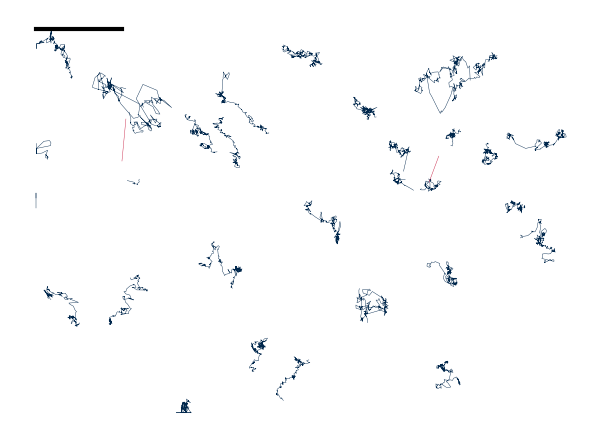

In [5]:
   
idx = 0
# load condensate trajectories
fname_track = lst_fname_tracks[idx]
df = pd.read_csv(fname_track)
df = df.sort_values(by=["trackID", "t"])
# load cell boundaries within the FOV
fname_prefix = fname_track.split("_reformatted")[0]
lst_cells_within_FOV = [f for f in lst_fname_cell if f.startswith(fname_prefix)]
lst_cell_coords = [pd.read_csv(f, sep="	", header=None) for f in lst_cells_within_FOV]
# Plot
fig, ax = plt.subplots(1, 1)
trackIDs = df["trackID"].unique()
for trackID in track(trackIDs):
    current_track = df[df["trackID"] == trackID]
    current_x = current_track["x"].to_numpy()
    current_y = current_track["y"].to_numpy()
    flags = current_track["step_flag"].to_numpy()
    false_ranges = find_consecutive_false_ranges(flags)
    for start, end in false_ranges:
        jump_x = current_x[start : end + 1]
        jump_y = current_y[start : end + 1]
        plt.plot(
            jump_x,
            jump_y,
            ls='-',
            c=color_blue,
            lw=0.3,
        )

    true_ranges = find_consecutive_true_ranges(flags)
    for start, end in true_ranges:
        jump_x = current_x[start : end + 1]
        jump_y = current_y[start : end + 1]
        plt.plot(
            jump_x,
            jump_y,
            ls='-',
            c=color_red,
            lw=0.3,
        )

# plot cell coordinates
y_pos = 0
for cell_coords in lst_cell_coords:
    x = cell_coords.iloc[:, 0].to_numpy()
    y = cell_coords.iloc[:, 1].to_numpy()
    plt.plot(x, y, c="gray", ls="-", lw=0.5)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, c="gray", ls="-", lw=0.5)
    if y_pos < y.max():
        y_pos = y.max()
# add scale bar
scalebar_length_um = 2
scalebar_length_pxl = scalebar_length_um / 0.117
x_pos = 0
y_pos = y_pos + 0
plt.plot(
    [x_pos, x_pos + scalebar_length_pxl],
    [y_pos, y_pos],
    lw=3,
    ls="-",
    c="k",
)
# adjust plot parameters
plt.gca().invert_yaxis()
plt.tight_layout()
plt.axis("scaled")
plt.axis("off")
plt.savefig(
    fname_prefix + "-overlay.png",
    format="png",
    bbox_inches="tight",
    dpi=1200,
)